In [1]:
##### Import Libraries , Librosa - For Audio Analysis
import librosa 
import librosa.display
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
##### Change Directory to Folder Which Contains 24 Folders, each corresponding to an actor. 
import os
os.chdir("Audio_Speech_Actors_01-24")

In [5]:
os.getcwd()

'D:\\DSPPRojectfiles\\RAVDESS\\Audio_Speech_Actors_01-24'

# Plotting Functions for Waveform, Spectrogram and Mel-Spectrogram

In [6]:
## Waveform
def plotwave(signal):
    plt.plot(signal)
    plt.xticks(np.linspace(0,66150,7),[0,.5,1,1.5,2,2.5,3])
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

## Spectrogram
def plotspecgram(signal,sample_rate=22050):
    plt.specgram(signal,Fs=sample_rate)
    plt.xlabel("Time")
    plt.ylabel("Frequency")

## MelSpectrogram (Analogous to human hearing)
def plotmelspec(signal,sample_rate=22050):
    librosa.display.specshow(librosa.power_to_db(librosa.feature.melspectrogram(signal,sample_rate,power=2,fmax=3000),
                                             ref=np.max),x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel spectrogram')
    plt.xlabel("Time")
    plt.ylabel("Frequency")    
    plt.tight_layout()

# Data Processing

In [7]:
dirlist = os.listdir()
if '.DS_Store' in dirlist:
    dirlist.remove('.DS_Store')  ## This is for MAC users, since a hidden folder (.DS_Store) will be created when any file deleted in that respective folder.
dirlist.sort()

In [8]:
dirlist

['Actor_01',
 'Actor_02',
 'Actor_03',
 'Actor_04',
 'Actor_05',
 'Actor_06',
 'Actor_07',
 'Actor_08',
 'Actor_09',
 'Actor_10',
 'Actor_11',
 'Actor_12',
 'Actor_13',
 'Actor_14',
 'Actor_15',
 'Actor_16',
 'Actor_17',
 'Actor_18',
 'Actor_19',
 'Actor_20',
 'Actor_21',
 'Actor_22',
 'Actor_23',
 'Actor_24']

In [9]:
###### Audio File Naming Convention Encodings
emotion = {'01':"Neutral","02":"Calm","03":"Happy","04":"Sad","05":"Angry","06":"Fearful","07":"Disgust","08":"Surprised"}
intensity = {'01':"Normal",'02':"Strong"}
statement = {'01':"Kids are talking by the door",'02':"Dogs are sitting by the door"}
repitition = {'01':"First",'02':"Second"}

#sample_rate=22050

In [10]:
##### Loading the Audio Files
audiolist = list()
metadatalist = list()

for folder in dirlist:
    os.chdir(folder)
    files = os.listdir()
    if '.DS_Store' in files:
        files.remove('.DS_Store')
    files.sort()
    for file in files:
        codes = file.replace(".wav","").split("-")
        voice_clip,sample_rate = librosa.load(file,res_type="kaiser_fast",duration=3)   ##returns audio time series and sampling rate
        audiolist.append(voice_clip)
        metadatalist.append([file,codes[2],emotion[codes[2]],intensity[codes[3]],statement[codes[4]],repitition[codes[5]],codes[6]])
    os.chdir("..")    

In [11]:
metadf = pd.DataFrame(metadatalist,columns=["filename","label","emotion","intensity","sentence","rep","actor"])
metadf.head()

,filename,label,emotion,intensity,sentence,rep,actor
0,03-01-01-01-01-01-01.wav,01,Neutral,Normal,Kids are talking by the door,First,01
1,03-01-01-01-01-02-01.wav,01,Neutral,Normal,Kids are talking by the door,Second,01
2,03-01-01-01-02-01-01.wav,01,Neutral,Normal,Dogs are sitting by the door,First,01
3,03-01-01-01-02-02-01.wav,01,Neutral,Normal,Dogs are sitting by the door,Second,01
4,03-01-02-01-01-01-01.wav,02,Calm,Normal,Kids are talking by the door,First,01


In [12]:
fulldf = pd.concat([metadf,pd.Series(audiolist)],axis=1)
fulldf.rename(columns={0:"audio"},inplace=True)

In [13]:
fulldf["label"]=pd.to_numeric(fulldf["label"])-1  ##for Keras

In [14]:
fulldf["label"].value_counts()

6    192
5    192
4    192
3    192
2    192
7    191
1    191
0     96
Name: label, dtype: int64

# Visualising the audio signals

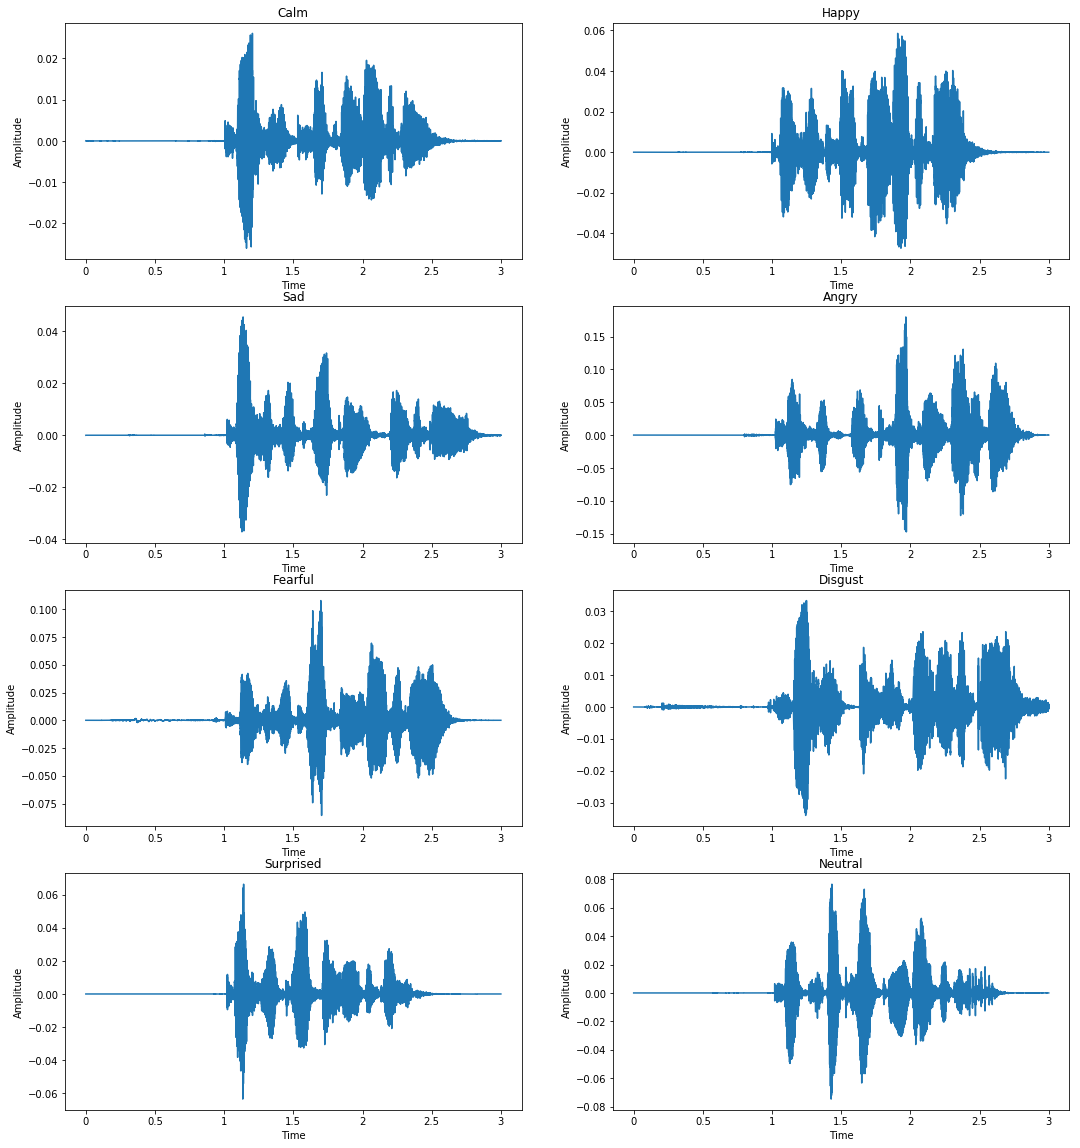

In [16]:
##### Waveforms of all 8 emotions
arr = [4,12,20,28,36,44,52,60]
plt.figure(figsize=(18,20))

for i in range(1,9):
    plt.subplot(4,2,i)
    plotwave(fulldf["audio"][arr[i-1]])
    plt.title(fulldf["emotion"][arr[i-1]])

plt.savefig("waveform.png") 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:7564: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


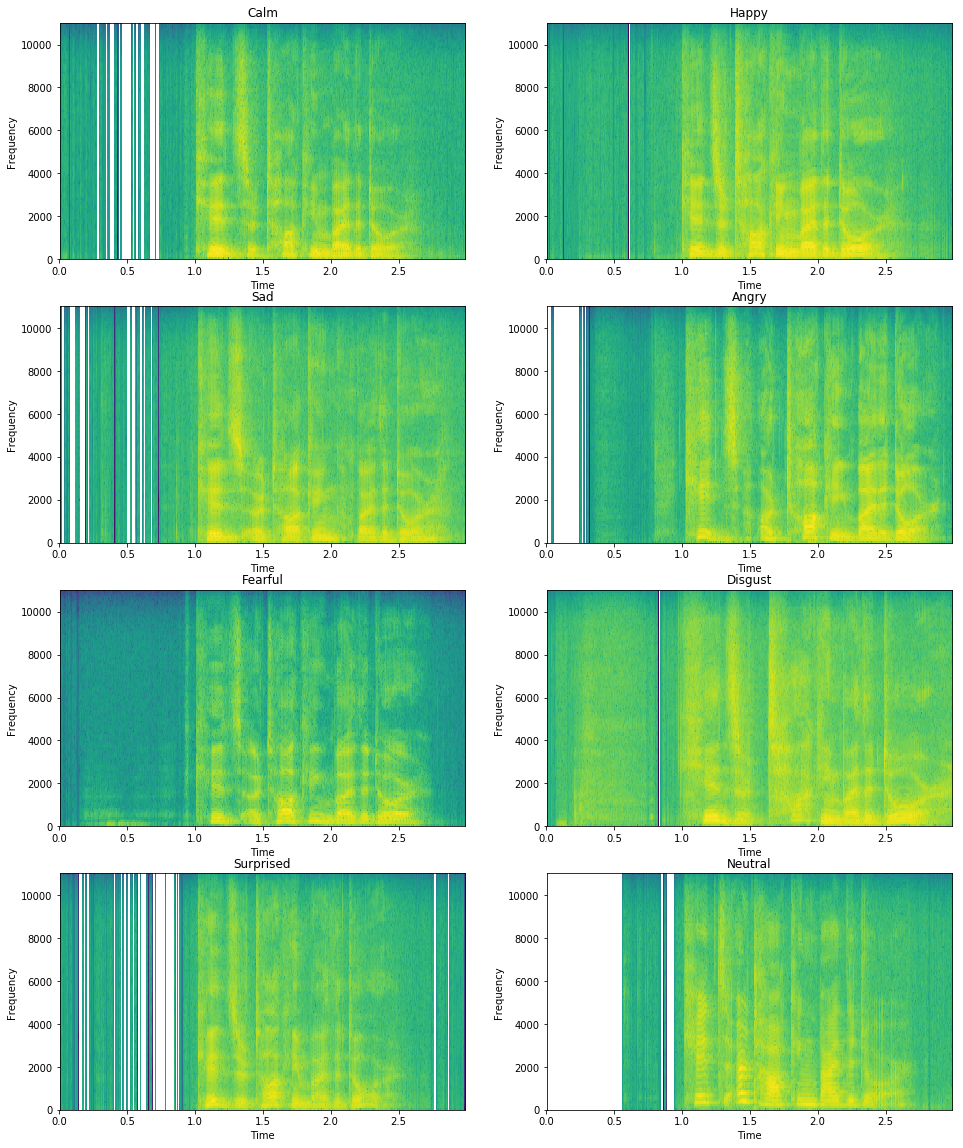

In [17]:
##### Spectrogram of all 8 emotions
plt.figure(figsize=(16,20))

for i in range(1,9):
    plt.subplot(4,2,i)
    plotspecgram(fulldf["audio"][arr[i-1]])
    plt.title(fulldf["emotion"][arr[i-1]])
    
plt.savefig("specgram.pdf")    

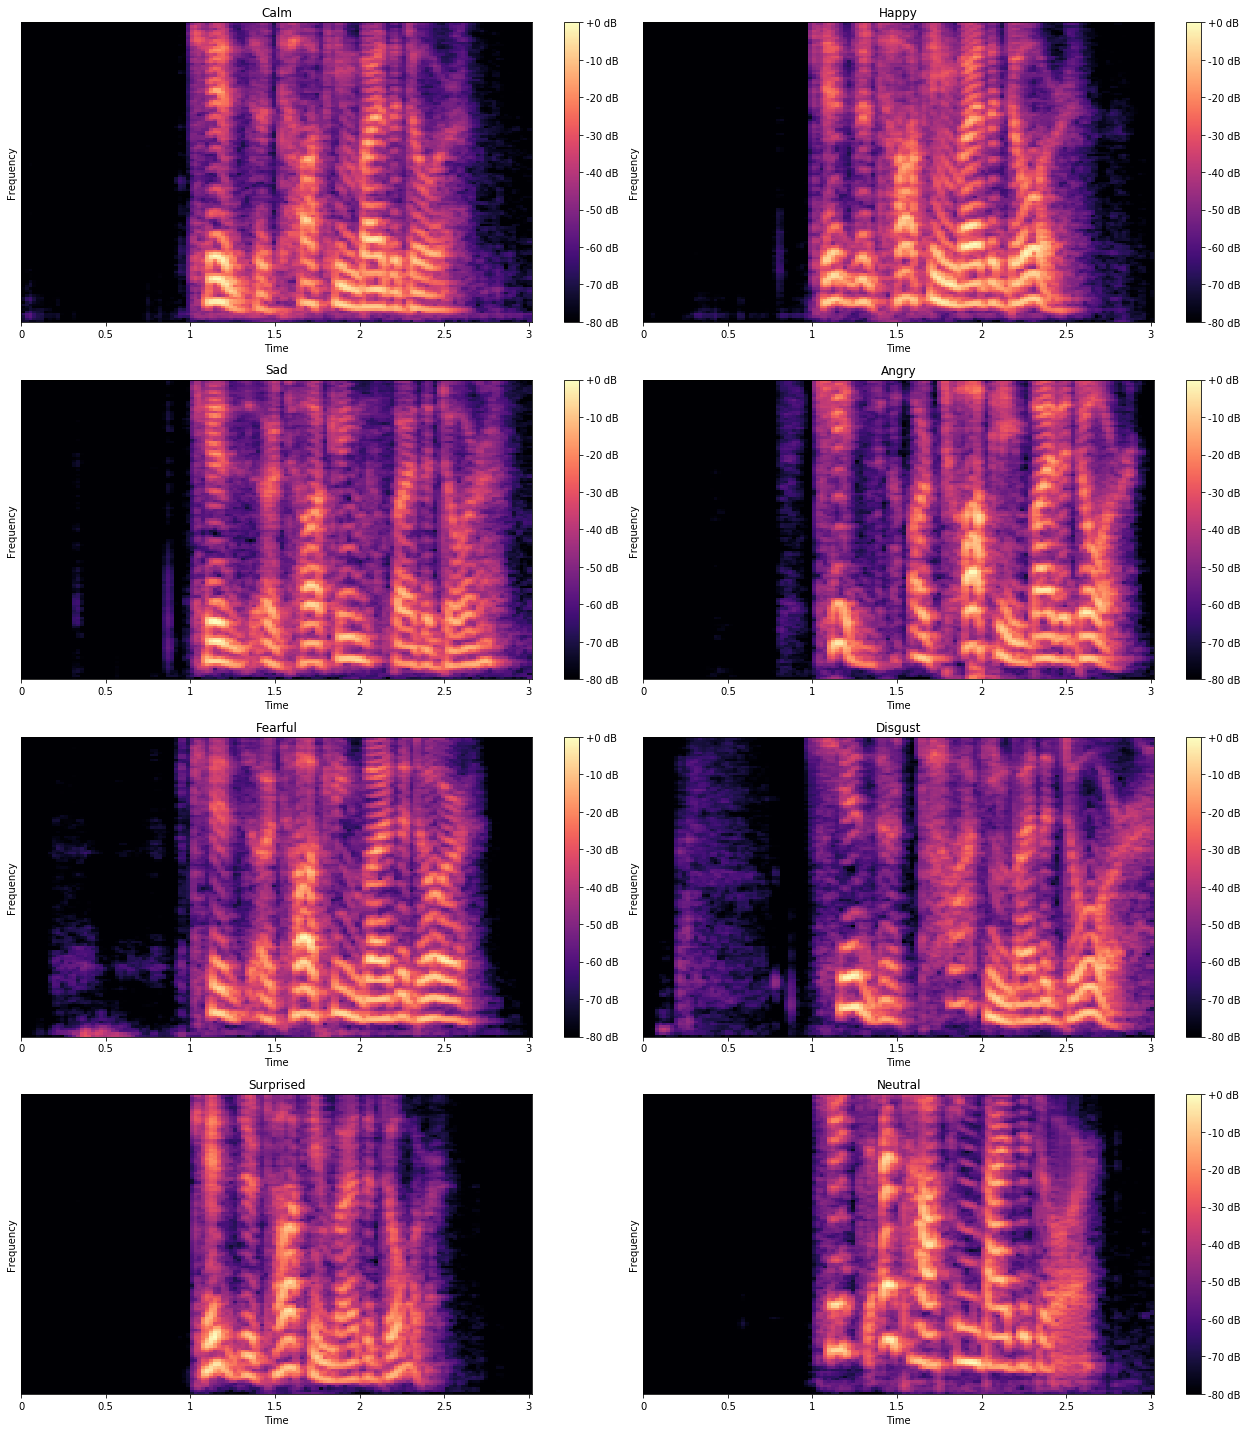

In [18]:
##### Melpower Spectrogram for all 8 emotions
plt.figure(figsize=(18,20))

for i in range(1,9):
    plt.subplot(4,2,i)
    plotmelspec(fulldf["audio"][arr[i-1]])
    plt.title(fulldf["emotion"][arr[i-1]])

plt.savefig("melpowerspec.png") 

# Random Forest Model

In [19]:
## Converting each audio file into its respective 1D melspectrogram input array
mellist = list(map(lambda x: np.mean(librosa.power_to_db(librosa.feature.melspectrogram(x,sample_rate,power=2,fmax=3000),ref=np.max),axis=1),fulldf["audio"]))


In [20]:
meldf = pd.DataFrame(mellist)
meldf = pd.concat([meldf,metadf["emotion"]],axis=1)
meldf.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,emotion
0,-73.819639,-68.438565,-62.437840,-58.061493,-56.862091,-51.930602,-53.044357,-54.097107,-57.660349,-56.750038,...,-64.465109,-65.786638,-66.268822,-66.628362,-66.791703,-66.510553,-67.643182,-67.591488,-67.124983,Neutral
1,-73.259319,-65.789786,-59.876620,-56.855749,-56.768218,-51.960309,-51.635593,-52.493087,-54.640997,-54.966986,...,-62.943869,-63.568520,-64.954434,-64.847719,-64.400662,-64.567742,-65.821441,-65.753406,-64.881829,Neutral
2,-73.966949,-67.828386,-62.817125,-59.899594,-57.892598,-52.635705,-53.158135,-54.681820,-57.523609,-57.801966,...,-66.466877,-66.555696,-67.371411,-67.704778,-67.275575,-67.175968,-67.964744,-68.124499,-67.325705,Neutral
3,-74.604037,-67.580473,-62.007355,-58.486044,-56.699894,-52.060523,-52.217772,-54.077747,-57.632450,-58.125166,...,-66.639356,-67.304979,-67.867960,-68.093805,-67.669800,-67.411436,-67.979283,-68.211023,-68.011916,Neutral
4,-69.967869,-62.850961,-57.126324,-54.561972,-52.515395,-47.339486,-47.998782,-48.964263,-50.694359,-51.241157,...,-62.058974,-61.765611,-62.868255,-63.976838,-63.794707,-63.750636,-65.204599,-65.426261,-65.069530,Calm


In [21]:
## Train Test Split
dat_train = meldf[0:1198][:] 
dat_train = dat_train.iloc[np.random.randint(0,len(dat_train),len(dat_train)),:]
dat_test = meldf[1198:1439][:]
dat_test = dat_test.iloc[np.random.randint(0,len(dat_test),len(dat_test)),:]

In [22]:
X_train = dat_train.iloc[:,0:128]
X_test = dat_test.iloc[:,0:128]

In [23]:
y_train = dat_train.iloc[:,128]
y_test = dat_test.iloc[:,128]

In [24]:
print(X_train.shape)
print(y_train.shape)

(1198, 128)
(1198,)


In [25]:
## Training Random Forest Model
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=200,max_depth=7).fit(X_train,y_train)
testpreds = model.predict(X_test)
trainpreds = model.predict(X_train)

In [27]:
# Train Accuracy
from sklearn.metrics import accuracy_score,confusion_matrix
print(confusion_matrix(y_train,trainpreds))
print(accuracy_score(y_train,trainpreds))

[[176   1   1   0   0   0   1   1]
 [  0 162   0   1   0   0   0   3]
 [  2   1 140   1   0   0   0   0]
 [  1   3   3 150   0   0   0   1]
 [  0   3   0   0 153   0   1   2]
 [  0   4   1   0   1  64   1   7]
 [  1   6   0   2   0   0 158   0]
 [  1   3   2   0   1   0   0 139]]
0.9532554257095158


In [28]:
# Test Accuracy
print(confusion_matrix(y_test,testpreds))
print(accuracy_score(y_test,testpreds))

[[22  0  0 10  2  0  0  1]
 [ 1  8  3  0  2  0  6  4]
 [ 9  4  3  0  2  0  3  6]
 [ 9  4  1  4  8  0  1  4]
 [10  0  4  8  4  0  1  4]
 [ 2  9  2  0  0  2  1  3]
 [ 5 21  0  3  2  0  1  0]
 [ 9  0  5  3  1  0  0 23]]
0.2791666666666667


# Convolution Neural Network

In [29]:
## Converting each audio file into its respective 2D melspectrogram image
mellistimage = list(map(lambda x: librosa.power_to_db(librosa.feature.melspectrogram(x,sample_rate,power=2,fmax=3000),ref=np.max),fulldf["audio"]))


In [30]:
len(mellistimage)

1438

In [31]:
## Normalising the input image before feeding it to input layer of CNN
normimage = list(map(lambda img: ((img.flatten() - np.mean(img)) / np.std(img)).reshape(128,130),mellistimage))

In [32]:
## Reshaping the dataset as per the keras CNN
melimgarray = [np.array(l).reshape(128,130,1) for l in normimage]

mel3darray = np.dstack(melimgarray)
mel3darray = mel3darray.reshape(1438,128,130,1)

In [33]:
mel3darray.shape

(1438, 128, 130, 1)

In [34]:
#Shuffling Indices, Train-Test Splitting.
np.random.seed(42)
shuffle = np.random.randint(0,1198,1198)

X_train = mel3darray[0:1198,:,:]
X_train = X_train[shuffle,:,:]

X_test = mel3darray[1198:1439,:,:]

y_train = fulldf["label"][0:1198]
y_train = y_train[shuffle]

y_test = fulldf["label"][1198:1439]

print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1198, 128, 130, 1) (240, 128, 130, 1) (1198,) (240,)


In [35]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [36]:
## One-hot encoding of target variables
y_cat_train = to_categorical(y_train,8)
y_cat_test = to_categorical(y_test,8)

In [37]:
y_train.shape

(1198,)

In [38]:
y_cat_train.shape

(1198, 8)

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,ZeroPadding2D,Convolution2D,Dropout
from keras.optimizers import SGD,RMSprop
from keras import backend as K

Using TensorFlow backend.


In [31]:
K.clear_session()

In [32]:
#create model
model = Sequential()

# #add model layers
model.add(Conv2D(256, kernel_size=3, activation="relu", input_shape=(128,130,1)))
## input shape <- 128 x 130 image with 1 channel
## kernel_size is the height and width of the 2D convolution window
## strides=(1, 1) by default, which specifies the strides of the convolution along the height and width 
## relu activation function
##

#model.add(Conv2D(128, kernel_size=3, activation="relu"))
#model.add(Dropout(0.1))
model.add(MaxPooling2D((2,2),strides=(2,2)))

model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(Dropout(0.1))            ## To drop out a set of random neurons
model.add(Conv2D(128, kernel_size=3, activation="relu"))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(8, activation="softmax"))

## VGG-16 (Visual Geometry Group)
# model.add(ZeroPadding2D((1,1),input_shape=(128,130,1)))
# model.add(Convolution2D(64, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(64, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))


# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(128, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))

# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, (3, 3), activation='relu'))
# model.add(ZeroPadding2D((1,1)))
# model.add(Convolution2D(512, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2,2), strides=(2,2)))

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(8, activation='softmax'))

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 128, 256)     2560      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 62, 128)       295040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 62, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 60, 128)       147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 453120)            0         
__________

In [34]:
## Various optimization methods
opt = RMSprop(lr=0.00001, decay=1e-6)
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
## Training the Convolution Neural Network
trainingepoch=model.fit(X_train, y_cat_train, validation_data=(X_test, y_cat_test), epochs=100,batch_size=32)

Train on 1198 samples, validate on 240 samples
Epoch 1/100
1198/1198 [==============================] - 165s 137ms/step - loss: 2.0611 - acc: 0.1561 - val_loss: 2.0743 - val_acc: 0.1375
Epoch 2/100
1198/1198 [==============================] - 161s 134ms/step - loss: 2.0142 - acc: 0.2229 - val_loss: 2.0660 - val_acc: 0.1333
Epoch 3/100
1198/1198 [==============================] - 162s 135ms/step - loss: 1.9717 - acc: 0.2654 - val_loss: 2.0651 - val_acc: 0.1333
Epoch 4/100
1198/1198 [==============================] - 161s 134ms/step - loss: 1.9205 - acc: 0.3598 - val_loss: 2.0662 - val_acc: 0.1542
Epoch 5/100
1198/1198 [==============================] - 162s 135ms/step - loss: 1.8648 - acc: 0.4107 - val_loss: 2.0616 - val_acc: 0.1375
Epoch 6/100
1198/1198 [==============================] - 164s 137ms/step - loss: 1.7990 - acc: 0.4399 - val_loss: 2.0711 - val_acc: 0.1625
Epoch 7/100
1198/1198 [==============================] - 164s 137ms/step - loss: 1.7348 - acc: 0.5125 - val_loss: 2.071

In [36]:
trainingepoch

In [39]:
print(trainingepoch.history['val_acc'])

[0.1375, 0.13333333333333333, 0.13333333333333333, 0.15416666666666667, 0.1375, 0.1625, 0.13333333333333333, 0.20416666666666666, 0.19166666666666668, 0.14166666666666666, 0.15416666666666667, 0.25416666666666665, 0.23333333333333334, 0.26666666666666666, 0.24583333333333332, 0.25416666666666665, 0.2625, 0.2833333333333333, 0.30416666666666664, 0.3375, 0.3375, 0.2916666666666667, 0.37916666666666665, 0.3458333333333333, 0.37083333333333335, 0.4041666666666667, 0.4625, 0.4375, 0.39166666666666666, 0.425, 0.42916666666666664, 0.5083333333333333, 0.525, 0.49583333333333335, 0.5541666666666667, 0.5041666666666667, 0.5916666666666667, 0.5375, 0.55, 0.5666666666666667, 0.475, 0.5833333333333334, 0.5458333333333333, 0.6208333333333333, 0.6041666666666666, 0.5083333333333333, 0.6291666666666667, 0.6166666666666667, 0.6166666666666667, 0.5625, 0.6041666666666666, 0.6333333333333333, 0.6708333333333333, 0.6625, 0.6083333333333333, 0.6041666666666666, 0.6416666666666667, 0.6541666666666667, 0.633

In [55]:
model.save('/Users/rohithmovva/Downloads/DSP_Project_Files/EmotionDetectionModel.h5')

In [56]:
from keras.models import load_model

In [57]:
savedmodel=load_model('/Users/rohithmovva/Downloads/DSP_Project_Files/EmotionDetectionModel.h5')

In [58]:
savedmodel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 128, 256)     2560      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 64, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 62, 128)       295040    
_________________________________________________________________
dropout_1 (Dropout)          (None, 61, 62, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 59, 60, 128)       147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 59, 60, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 453120)            0         
__________

In [59]:
savedpreds = savedmodel.predict(X_test)

In [60]:
preds = [np.argmax(pred) for pred in savedpreds]

In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
confmat = confusion_matrix(y_test,preds)

In [63]:
(sum(confmat.diagonal())/ 240 ) * 100

65.0

In [66]:
emotion = {0:"Neutral",1:"Calm",2:"Happy",3:"Sad",4:"Angry",5:"Fearful",6:"Disgust",7:"Surprised"}

In [67]:
labelpreds = [emotion[pred] for pred in preds]
labely_test = [emotion[pred] for pred in y_test]

In [68]:
pd.Series(labely_test).value_counts()

Sad          32
Fearful      32
Disgust      32
Surprised    32
Happy        32
Calm         32
Angry        32
Neutral      16
dtype: int64

In [69]:
labels=["Angry","Calm","Disgust","Fearful","Happy","Neutral","Sad","Surprised"]
print(pd.DataFrame(confusion_matrix(labely_test,labelpreds,labels=labels), index=labels, columns=labels))

           Angry  Calm  Disgust  Fearful  Happy  Neutral  Sad  Surprised
Angry         23     4        0        1      1        1    2          0
Calm           2    24        1        3      2        0    0          0
Disgust        1     1       17        4      5        0    1          3
Fearful        3     6        2       18      3        0    0          0
Happy          0     2        0        1     26        0    3          0
Neutral        6     0        0        1      0        7    0          2
Sad            4     0        0        0      5        0   19          4
Surprised      5     0        1        0      0        0    4         22


In [147]:
[(i,act,pred)for (i,act,pred) in zip(range(0,len(labelpreds)),labelpreds,labely_test)]

[(0, 'Angry', 'Neutral'),
 (1, 'Angry', 'Neutral'),
 (2, 'Neutral', 'Neutral'),
 (3, 'Angry', 'Neutral'),
 (4, 'Calm', 'Calm'),
 (5, 'Calm', 'Calm'),
 (6, 'Angry', 'Calm'),
 (7, 'Calm', 'Calm'),
 (8, 'Calm', 'Calm'),
 (9, 'Calm', 'Calm'),
 (10, 'Calm', 'Calm'),
 (11, 'Fearful', 'Calm'),
 (12, 'Calm', 'Happy'),
 (13, 'Happy', 'Happy'),
 (14, 'Happy', 'Happy'),
 (15, 'Happy', 'Happy'),
 (16, 'Happy', 'Happy'),
 (17, 'Happy', 'Happy'),
 (18, 'Happy', 'Happy'),
 (19, 'Sad', 'Happy'),
 (20, 'Sad', 'Sad'),
 (21, 'Sad', 'Sad'),
 (22, 'Angry', 'Sad'),
 (23, 'Sad', 'Sad'),
 (24, 'Sad', 'Sad'),
 (25, 'Sad', 'Sad'),
 (26, 'Surprised', 'Sad'),
 (27, 'Sad', 'Sad'),
 (28, 'Angry', 'Angry'),
 (29, 'Angry', 'Angry'),
 (30, 'Angry', 'Angry'),
 (31, 'Angry', 'Angry'),
 (32, 'Angry', 'Angry'),
 (33, 'Calm', 'Angry'),
 (34, 'Angry', 'Angry'),
 (35, 'Calm', 'Angry'),
 (36, 'Angry', 'Fearful'),
 (37, 'Fearful', 'Fearful'),
 (38, 'Fearful', 'Fearful'),
 (39, 'Fearful', 'Fearful'),
 (40, 'Fearful', 'Fearful')

In [73]:
trainingepoch.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

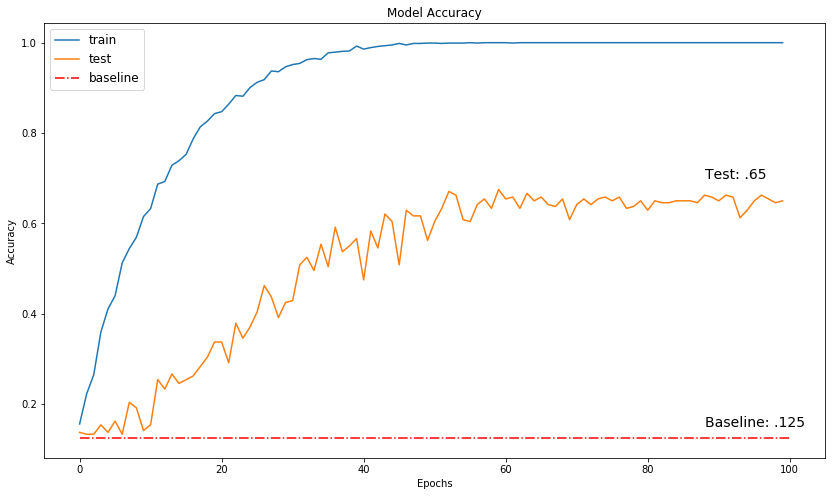

In [167]:
plt.figure(figsize=(14,8))
plt.plot(trainingepoch.history['acc'])
plt.plot(trainingepoch.history['val_acc'])
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.hlines(.1250,0,100,linestyles="dashdot",color="red",label=".125")
plt.legend(["train","test","baseline"],fontsize="large")
plt.text(88,.15,"Baseline: .125",fontsize=14)
plt.text(88,.70,"Test: .65",fontsize=14)
plt.show()